<a href="https://colab.research.google.com/github/delhian/ComputerVision/blob/main/pytorch/CV_md7_screencast_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Решение задачи классификации при помощи pytorch

In [1]:
from google.colab import drive
drive.mount('/content/drive', )

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Во втором ноутбуке по классификации изображений мы непосредственно обучим сверточную модель для классификации.

Импортируем также все необходимые и вспомогательные библиотеки:

In [2]:
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)

BATCH_SIZE = 32

1.10.0+cu111
0.11.1+cu111


In [3]:
pwd

'/content'

In [7]:
!rm -r /content/artists/

## Данные для классификации

Для примера мы будем решать задачу идентификации художника по его картине.

В качестве данных возьмем датасет [Best Artworks of All Time](https://www.kaggle.com/ikarus777/best-artworks-of-all-time/) на платформе Kaggle.

In [8]:
!unzip /content/drive/MyDrive/best-artworks-of-all-time.zip -d /content/artists/ >> /dev/null

Сколько всего представлено художников в датасете:

In [9]:
!ls artists/ | wc -l

3


In [10]:
!ls artists

artists.csv  images  resized


Сколько всего представлено произведений искусства в датасете:

In [11]:
!find artists/ -type f | wc -l

17458


Для обучения на этих данных нам нужно получить объекты класса `Dataset` для дальнейшей работы с ними.

В рамках предыдущих скринкастов мы упоминали готовый класс `ImageFolder`,
который как раз работает с директориями такого вида.

Давайте создадим объект датасета по всем изображениям и изучим его:

In [12]:
from torchvision.datasets import ImageFolder

artists_dataset = ImageFolder("artists/")

Как выглядит один сэмпл из датасета?

In [13]:
artists_dataset[0]

(<PIL.Image.Image image mode=RGB size=720x1024 at 0x7F51F8DF9C90>, 0)

Это изображение класса `PIL.Image` и метка класса. А какой метке соответствует класс?

In [14]:
import inspect

print(inspect.getsource(ImageFolder))

class ImageFolder(DatasetFolder):
    """A generic data loader where the images are arranged in this way by default: ::

        root/dog/xxx.png
        root/dog/xxy.png
        root/dog/[...]/xxz.png

        root/cat/123.png
        root/cat/nsdf3.png
        root/cat/[...]/asd932_.png

    This class inherits from :class:`~torchvision.datasets.DatasetFolder` so
    the same methods can be overridden to customize the dataset.

    Args:
        root (string): Root directory path.
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
        loader (callable, optional): A function to load an image given its path.
        is_valid_file (callable, optional): A function that takes path of an Image file
            and check if the file is a valid file (u

In [15]:
from torchvision.datasets import DatasetFolder

print(inspect.getsource(DatasetFolder.__init__))

    def __init__(
            self,
            root: str,
            loader: Callable[[str], Any],
            extensions: Optional[Tuple[str, ...]] = None,
            transform: Optional[Callable] = None,
            target_transform: Optional[Callable] = None,
            is_valid_file: Optional[Callable[[str], bool]] = None,
    ) -> None:
        super(DatasetFolder, self).__init__(root, transform=transform,
                                            target_transform=target_transform)
        classes, class_to_idx = self.find_classes(self.root)
        samples = self.make_dataset(self.root, class_to_idx, extensions, is_valid_file)

        self.loader = loader
        self.extensions = extensions

        self.classes = classes
        self.class_to_idx = class_to_idx
        self.samples = samples
        self.targets = [s[1] for s in samples]



In [16]:
artists_dataset.classes[artists_dataset[0][1]]

'images'

Как выглядит само изображение?

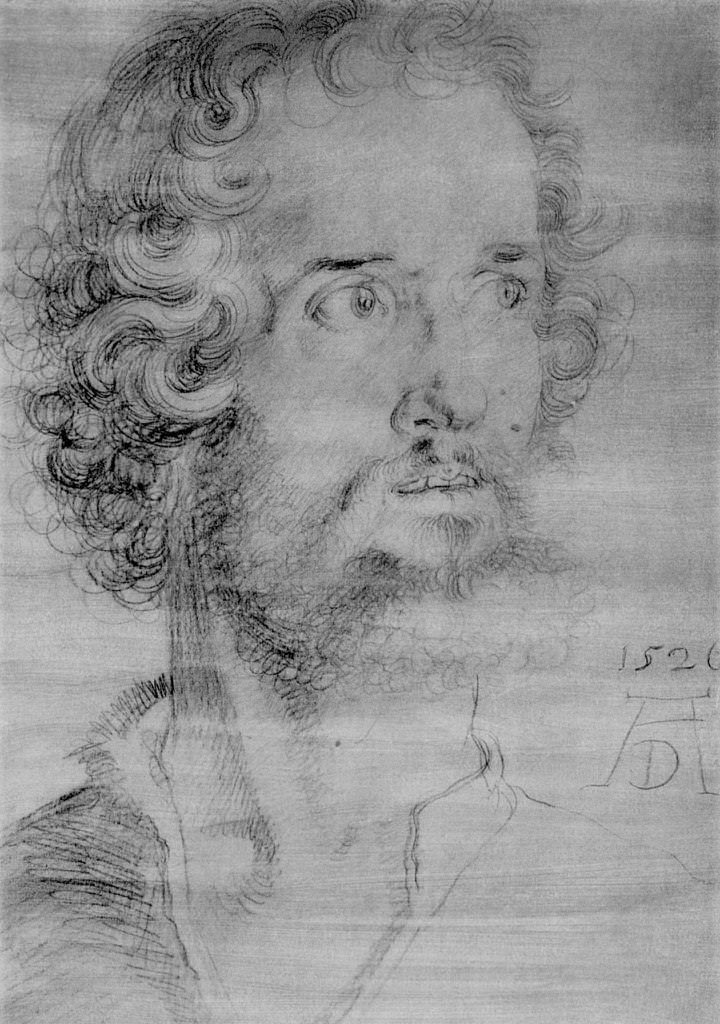

In [17]:
artists_dataset[0][0]

Посмотрим на другие случайные примеры из датасета:

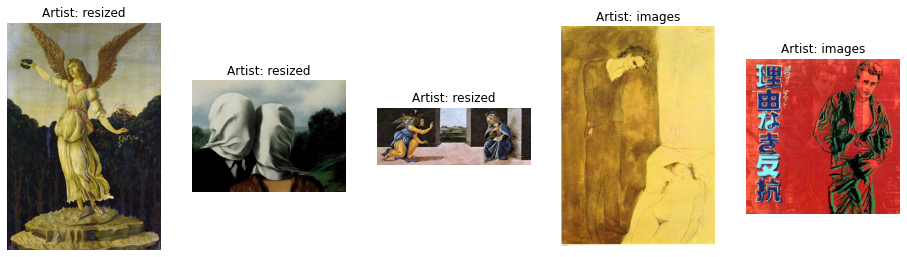

In [18]:
import random

def plot_samples(dataset, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(16, 8))

    for i in range(num_samples):
        random_image, random_class = random.choice(dataset)
        random_label = dataset.classes[random_class]
        axes[i].imshow(random_image)
        axes[i].set_title("Artist: " + random_label.replace("_", " "))
        axes[i].axis("off")

    plt.show()

plot_samples(artists_dataset)

## Подготовка обучения и валидации

Для обучения "как по учебнику" нам нужно разбить имеющиеся данные на обучение и валидацию.

В созданном объекте датасета хранятся пути всех сэмплов с метками:

In [19]:
artists_dataset.samples

[('artists/images/images/Albrecht_DuтХа├кrer/Albrecht_DuтХа├кrer_1.jpg', 0),
 ('artists/images/images/Albrecht_DuтХа├кrer/Albrecht_DuтХа├кrer_10.jpg', 0),
 ('artists/images/images/Albrecht_DuтХа├кrer/Albrecht_DuтХа├кrer_100.jpg', 0),
 ('artists/images/images/Albrecht_DuтХа├кrer/Albrecht_DuтХа├кrer_101.jpg', 0),
 ('artists/images/images/Albrecht_DuтХа├кrer/Albrecht_DuтХа├кrer_102.jpg', 0),
 ('artists/images/images/Albrecht_DuтХа├кrer/Albrecht_DuтХа├кrer_103.jpg', 0),
 ('artists/images/images/Albrecht_DuтХа├кrer/Albrecht_DuтХа├кrer_104.jpg', 0),
 ('artists/images/images/Albrecht_DuтХа├кrer/Albrecht_DuтХа├кrer_105.jpg', 0),
 ('artists/images/images/Albrecht_DuтХа├кrer/Albrecht_DuтХа├кrer_106.jpg', 0),
 ('artists/images/images/Albrecht_DuтХа├кrer/Albrecht_DuтХа├кrer_107.jpg', 0),
 ('artists/images/images/Albrecht_DuтХа├кrer/Albrecht_DuтХа├кrer_108.jpg', 0),
 ('artists/images/images/Albrecht_DuтХа├кrer/Albrecht_DuтХа├кrer_109.jpg', 0),
 ('artists/images/images/Albrecht_DuтХа├кrer/Albrecht_D

Воспользуемся функцией разбиения с учетом пропорций классов из библиотеки `scikit-learn` и выделим 1000 сэмплов для валидации:

In [23]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=1000, train_size=None, random_state=2021)

Разделим сэмплы на пути и метки:

In [24]:
X = [x[0] for x in artists_dataset.samples]
y = [x[1] for x in artists_dataset.samples]

Получим индексы для обучения и валидации:

In [25]:
train_idx, valid_idx = list(sss.split(X, y))[0]

print(len(train_idx), len(valid_idx))

16457 1000


Теперь создадим копии объекта (которые будут знать про структуру датасета и его классы) для наших сплитов:

In [26]:
from copy import copy

train_dataset = copy(artists_dataset)
train_dataset.samples = [artists_dataset.samples[i] for i in train_idx]
train_dataset.targets = [artists_dataset.targets[i] for i in train_idx]
train_dataset.imgs = train_dataset.samples

valid_dataset = copy(artists_dataset)
valid_dataset.samples = [artists_dataset.samples[i] for i in valid_idx]
valid_dataset.targets = [artists_dataset.targets[i] for i in valid_idx]
valid_dataset.imgs = valid_dataset.samples

print(len(train_dataset), len(valid_dataset))

16457 1000


Посмотрим на примеры из обучения и валидации:

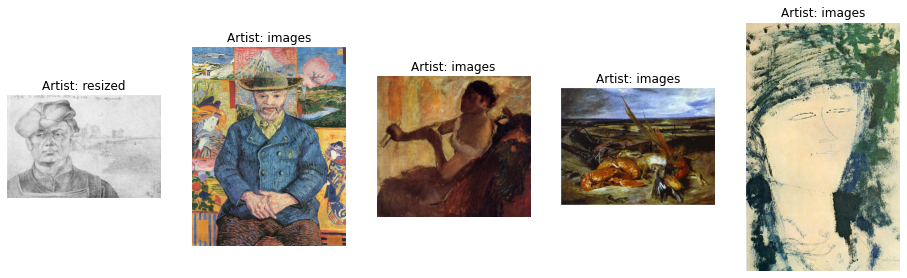

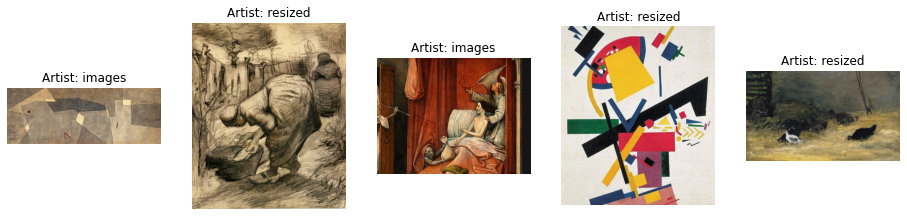

In [27]:
plot_samples(train_dataset)
plot_samples(valid_dataset)

Для того, чтобы использовать эти датасеты в процессе обучения, применим к ним стандартный препроцессинг в стиле ResNet:

In [28]:
from torchvision import transforms

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

train_dataset.transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])
valid_dataset.transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize
])

И обернуть в даталоадеры:

In [29]:
import os

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=os.cpu_count()
)

valid_loader = torch.utils.data.DataLoader(
    valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=os.cpu_count()
)

Теперь мы можем использовать данные для обучения:

In [30]:
for images, targets in tqdm(train_loader):
    # Здесь будет шаг обучения модели
    ...

100%|██████████| 515/515 [03:33<00:00,  2.41it/s]


## Обучение модели

Для обучение возьмем легковесную из семейства ResNet модель ResNet-34:

In [31]:
from torchvision import models

net = models.resnet34()

Заметим, что полносвязный слой сети рассчитан на 1000 классов:

In [32]:
net

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [33]:
net.fc

Linear(in_features=512, out_features=1000, bias=True)

Поэтому мы заменим его на полносвязный слой с нужным количеством классов:

In [34]:
net.fc = torch.nn.Linear(512, len(train_dataset.classes))

Функция потерь для обучения классификации — кроссэнтропия

In [35]:
criterion = torch.nn.CrossEntropyLoss()

Если доступен графический ускоритель, используем его:

In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = net.to(device)
criterion = criterion.to(device)

В качестве оптимизатора используем SGD с параметрами по умолчанию для обучения ResNet.

Единственное отличие в скорости обучения, которую мы уменьшили на пару порядков из-за размера датасета.

In [37]:
optimizer = torch.optim.SGD(net.parameters(), lr=1e-2, weight_decay=1e-4)

Обернем процесс обучения в одну функцию для переиспользования:

In [38]:
def train_model(net, optimizer, train_dataset, valid_dataset, num_epochs=10):
    loss_train = []
    top1_train = []
    loss_valid = []
    top1_valid = []

    for epoch in range(num_epochs):
        # переключаем torch в режим сохрания данных для рассчета градиентов
        torch.set_grad_enabled(True)
        # переключаем модель в режим обучения для хранения промежуточной информация
        net.train()

        losses = []
        equals = []

        for i, (images, target) in enumerate(tqdm(train_loader)):
            # переносим на GPU при возможности
            images = images.to(device)
            target = target.to(device)

            # считаем сырые предсказания и функцию потерь
            output = net(images)
            loss = criterion(output, target)

            # запоминаем функцию потерь и правильность предсказаний
            losses.append(loss.item())
            equals.extend([eq.item() for eq in output.argmax(1) == target])

            # делаем шаг обновления весов модели
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        loss_train.append(np.mean(losses))
        top1_train.append(np.mean(equals))

        # для валидации градиенты не нужны
        torch.set_grad_enabled(False)
        # переключаем модель в режим валидации (быстрее, не храним ничего лишнего)
        net.eval()

        losses = []
        equals = []

        for i, (images, target) in enumerate(tqdm(valid_loader)):
            # переносим на GPU при возможности
            images = images.to(device)
            target = target.to(device)

            # считаем сырые предсказания и функцию потерь
            output = net(images)
            loss = criterion(output, target)

            # запоминаем функцию потерь и правильность предсказаний
            losses.append(loss.item())
            equals.extend([eq.item() for eq in output.argmax(1) == target])

            # шаг обновления весов здесь не нужен
            ...

        loss_valid.append(np.mean(losses))
        top1_valid.append(np.mean(equals))

    return loss_train, top1_train, loss_valid, top1_valid

Обучим модель, построенную с нуля, в течение 10 эпох:

In [39]:
loss_train, top1_train, loss_valid, top1_valid = train_model(net, optimizer, train_dataset, valid_dataset, 10)

100%|██████████| 32/32 [00:15<00:00,  2.05it/s]


## Анализ обученной модели

Как изменяются функция потерь и точность классификации?

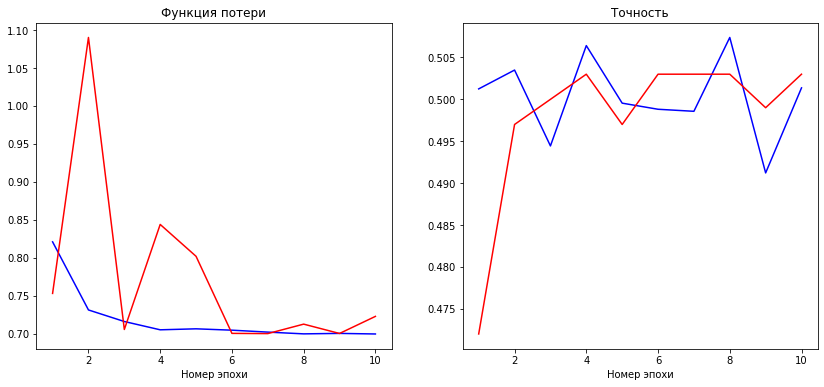

In [40]:
plt.figure(figsize=(14, 6))

plt.subplot(121)
plt.plot(range(1, len(loss_train) + 1), loss_train, color="b")
plt.plot(range(1, len(loss_train) + 1), loss_valid, color="r")
plt.xlabel("Номер эпохи")
plt.title("Функция потери")

plt.subplot(122)
plt.plot(range(1, len(loss_train) + 1), top1_train, color="b")
plt.plot(range(1, len(loss_train) + 1), top1_valid, color="r")
plt.xlabel("Номер эпохи")
plt.title("Точность")

plt.show()

Видим, что:
1) Точность растет и достигает значений лучше случайного предсказания (больше 30% при 50 классах);

2) На плато значений точности даже не начали выходить (после чего следовало бы уменьшить скорость обучения);

3) Точность похожая и на обучении, и при валидации, т.е. модель не переобучена.

## Использование предобученных весов

Попробуем обучить такую же модель, но начав с обученных на ImageNet весов:

In [41]:
net = models.resnet34(pretrained=True)
net.fc = torch.nn.Linear(512, len(train_dataset.classes))
net = net.to(device)

optimizer = torch.optim.SGD(net.parameters(), lr=1e-3, weight_decay=1e-4)

loss_train, top1_train, loss_valid, top1_valid = train_model(net, optimizer, train_dataset, valid_dataset, 10)

100%|██████████| 32/32 [00:15<00:00,  2.08it/s]


In [ ]:
plt.figure(figsize=(14, 6))

plt.subplot(121)
plt.plot(range(1, len(loss_train) + 1), loss_train, color="b")
plt.plot(range(1, len(loss_train) + 1), loss_valid, color="r")
plt.xlabel("Номер эпохи")
plt.title("Функция потери")

plt.subplot(122)
plt.plot(range(1, len(loss_train) + 1), top1_train, color="b")
plt.plot(range(1, len(loss_train) + 1), top1_valid, color="r")
plt.xlabel("Номер эпохи")
plt.title("Точность")

plt.show()

В данном случае модель достигла еще более высоких показателей точности за то же количество шагов обучения!

Отсюда следует сделать вывод, что использование готовых весов для старта позволяет добиться лучшего качества.

## Заморозка слоев и файн-тюнинг модели

Мы только что смогли обучить нейросетевую модель до приемлемого качества как с нуля, так и начиная с готовых весов.

Тем не менее в обоих случаях мы обновляли много миллионнов параметры, которые уже обучались на датасете с более чем 1.2 миллионами изображений и 1000 классами. А мы знаем, что на первых слоях сверточных сетей находятся нейроны, реагирующие на какие-то базовые признаки и паттерны. Может быть не следует пытаться их обучить вновь на нашем небольшом датасете со всего лишь десятками тысяч изображений?

Для того чтобы избежать обновления части весов, их можно "заморозить" — при обучении параметры этих слоев не будут меняться.

In [ ]:
print(inspect.getsource(models.resnet34))

In [44]:
print(inspect.getsource(models.resnet._resnet))

def _resnet(
    arch: str,
    block: Type[Union[BasicBlock, Bottleneck]],
    layers: List[int],
    pretrained: bool,
    progress: bool,
    **kwargs: Any
) -> ResNet:
    model = ResNet(block, layers, **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model



In [45]:
print(inspect.getsource(models.ResNet.__init__))

    def __init__(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        layers: List[int],
        num_classes: int = 1000,
        zero_init_residual: bool = False,
        groups: int = 1,
        width_per_group: int = 64,
        replace_stride_with_dilation: Optional[List[bool]] = None,
        norm_layer: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or

Крайним случаем заморозки весов является заморозка всей модели, кроме финального полносвязного слоя.

Обучение лишь полносвязного слоя (он обычно пересоздается как мы это уже делали) часто называют файн-тюнингом модели (fine tuning).

А в целом обучение модели для новой задачи, используя предобученные веса, называется трансфер лёрнингом (transfer learning).


Как реализовать заморозку и файн-тюнинг силами pytorch?

У каждого параметра питорчевого нейросетевого модуля (`model.parameters()`) есть параметр `requires_grad`.

По умолчанию они все выставлены в `requires_grad = True` и тем самым "разморожены".

Как заморозить часть модели ResNet?

In [46]:
net = models.resnet34(pretrained=True)
for module in [net.conv1, net.bn1, net.layer1, net.layer2]:
    for parameter in module.parameters():
        parameter.requres_grad = False

В этом примере мы заморозили все начальные слои и два из четырех крупных блока сети.

Это может быть полезно, когда данных много, но не настолько, чтобы обучать всю сеть целиком (около ста тысяч как пример).

Как реализовать файн-тюнинг? Можно заморозить все слои по очереди, а можно и проще — заморозить сеть, а уже потом пересоздать FC-слой:

In [47]:
net = models.resnet34(pretrained=True)
for parameter in net.parameters():
    parameter.requres_grad = False
net.fc = torch.nn.Linear(512, len(train_dataset.classes))
net = net.to(device)

А теперь обучим сеть файн-тюнингом, что может быть значительно быстрее (обновляется ведь только последний слой):

In [ ]:
optimizer = torch.optim.SGD(net.parameters(), lr=1e-3, weight_decay=1e-4)

loss_train, top1_train, loss_valid, top1_valid = train_model(net, optimizer, train_dataset, valid_dataset, 30)

 22%|██▏       | 114/515 [00:58<03:24,  1.96it/s]

In [ ]:
plt.figure(figsize=(14, 6))

plt.subplot(121)
plt.plot(range(1, len(loss_train) + 1), loss_train, color="b")
plt.plot(range(1, len(loss_train) + 1), loss_valid, color="r")
plt.xlabel("Номер эпохи")
plt.title("Функция потери")

plt.subplot(122)
plt.plot(range(1, len(loss_train) + 1), top1_train, color="b")
plt.plot(range(1, len(loss_train) + 1), top1_valid, color="r")
plt.xlabel("Номер эпохи")
plt.title("Точность")

plt.show()

## Предсказание построенной моделью

Загрузим фото с интерактивной выставки Ван Гога (т.к. это даже не картина)

In [ ]:
from PIL import Image

image = Image.open("vangogh.jpg")

image

Собираем батч и делаем предсказание:

In [ ]:
tensor = valid_dataset.transform(image)
batch = torch.stack([tensor])
with torch.no_grad():
    output = net(batch.to(device)).to("cpu")
predicted = output.argmax().item()

И кто же это?

In [ ]:
train_dataset.classes[predicted]

Работает даже так!